# Cross-task geometry comparison: ODR 1.5 s vs 3.0 s (split-half CV)

Compare Procrustes geometry between the two ODR delay durations
for the **4 common monkeys** (OLI, PIC, ROS, UNI).
All neurons from a monkey are pooled regardless of age.

**Split-half cross-validation:** on each iteration, every monkey’s
neurons are randomly split into two disjoint halves (A, B).
Representations are built per (monkey, split, task), giving
4 monkeys × 2 splits × 2 tasks = 16 entries per iteration.

Using only **cue** (0–500 ms) and **1.5 s delay** (500–2000 ms) epochs.

**Distance categories:**
1. Same monkey, within-task (different splits) — split-half reliability
2. Same monkey, cross-task — cross-task consistency
3. Different monkey, within-task
4. Different monkey, cross-task

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os, sys

sys.path.insert(0, '.')
from functions import (
    load_all_task_data,
    compute_flat_tuning, cross_task_cv, plot_cross_task,
)

DATA_DIR      = '../data_raw'
N_PCS         = 8
MIN_NEURONS   = N_PCS + 1
BIN_MS        = 50
COMMON_EPOCHS = {'cue': (0, 500), 'delay': (500, 2000)}
N_ITER        = 100
SEED          = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load data & filter to common monkeys

In [6]:
task_data = load_all_task_data(DATA_DIR)

common_monkeys = sorted(set(task_data['ODR 1.5s']['ids']) & set(task_data['ODR 3.0s']['ids']))
print(f'Common monkeys: {common_monkeys}')

odr_tasks = {}
for name in ['ODR 1.5s', 'ODR 3.0s']:
    mask = np.isin(task_data[name]['ids'], common_monkeys)
    odr_tasks[name] = dict(
        data=task_data[name]['data'][mask],
        ids=task_data[name]['ids'][mask],
    )
    print(f'{name}: {mask.sum()} neurons')

print('\nNeurons per monkey:')
for mid in common_monkeys:
    n15 = np.sum(odr_tasks['ODR 1.5s']['ids'] == mid)
    n30 = np.sum(odr_tasks['ODR 3.0s']['ids'] == mid)
    print(f'  {mid}: ODR 1.5s = {n15} (splits {n15//2} + {n15 - n15//2}), '
          f'ODR 3.0s = {n30} (splits {n30//2} + {n30 - n30//2})')

Common monkeys: [np.str_('OLI'), np.str_('PIC'), np.str_('ROS'), np.str_('UNI')]
ODR 1.5s: 391 neurons
ODR 3.0s: 922 neurons

Neurons per monkey:
  OLI: ODR 1.5s = 86 (splits 43 + 43), ODR 3.0s = 200 (splits 100 + 100)
  PIC: ODR 1.5s = 77 (splits 38 + 39), ODR 3.0s = 187 (splits 93 + 94)
  ROS: ODR 1.5s = 69 (splits 34 + 35), ODR 3.0s = 167 (splits 83 + 84)
  UNI: ODR 1.5s = 159 (splits 79 + 80), ODR 3.0s = 368 (splits 184 + 184)


## 2. Tuning curves (cue + 1.5 s delay)

In [7]:
task_configs = {
    'ODR 1.5s': dict(data=odr_tasks['ODR 1.5s']['data'], t_range=(-1000, 2500)),
    'ODR 3.0s': dict(data=odr_tasks['ODR 3.0s']['data'], t_range=(-1000, 3500)),
}

tuning_flat = {}
for name, cfg in task_configs.items():
    flat, _, _ = compute_flat_tuning(cfg['data'], cfg['t_range'], COMMON_EPOCHS, BIN_MS)
    tuning_flat[name] = flat
    print(f'{name}: {flat.shape[1]} features')

  neuron 0/391
ODR 1.5s: 16 features
  neuron 0/922
  neuron 500/922
ODR 3.0s: 16 features


## 3. Split-half cross-validation

In [8]:
task_ids = {name: odr_tasks[name]['ids'] for name in odr_tasks}
results = cross_task_cv(tuning_flat, task_ids, N_PCS, MIN_NEURONS, N_ITER, SEED)

  iteration 25/100
  iteration 50/100
  iteration 75/100
  iteration 100/100
Done.


## 4. Results and distance matrix

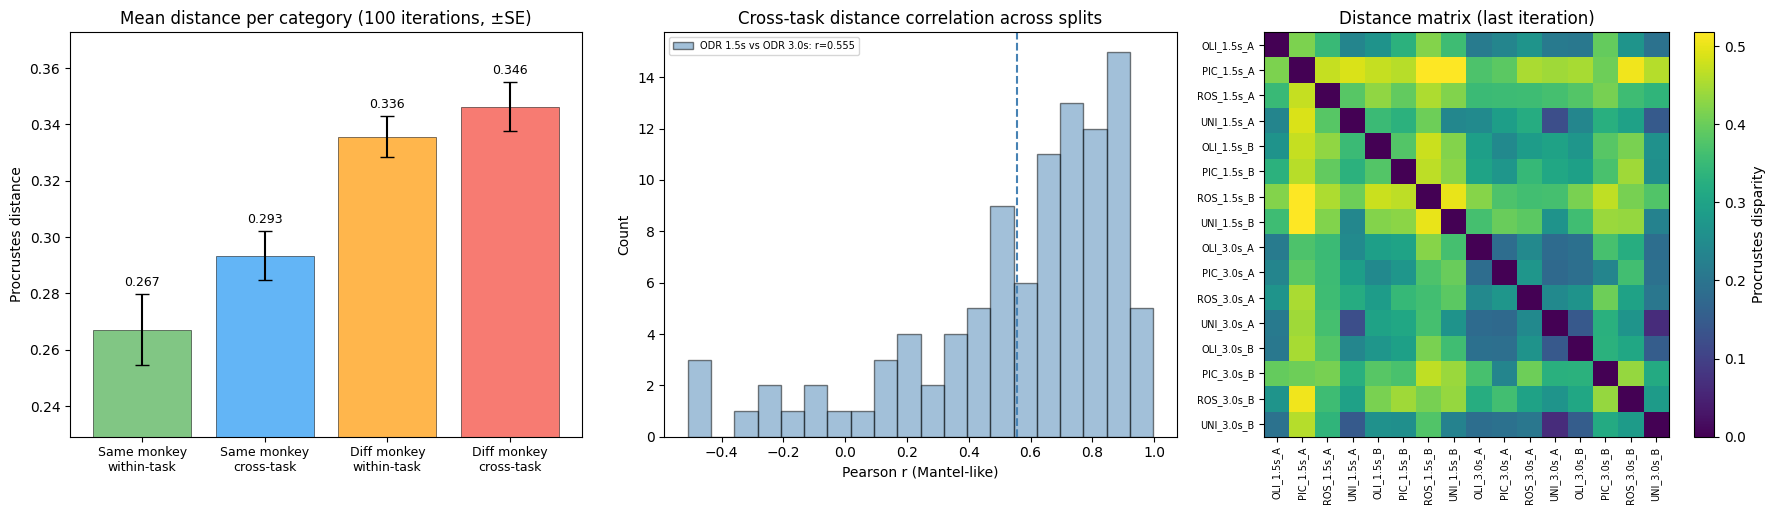

Category means [±SE]:
  Same monkey within-task         0.2672 ± 0.0125
  Same monkey cross-task          0.2935 ± 0.0086
  Diff monkey within-task         0.3356 ± 0.0073
  Diff monkey cross-task          0.3463 ± 0.0087

Mantel r:
  ODR 1.5s vs ODR 3.0s: mean = 0.555 ± 0.354 (SE)

Same monkey cross-task vs diff monkey within-task:
  diff median = -0.0422, 95% CI = [-0.0558, -0.0299], excludes zero
Same monkey cross-task vs diff monkey cross-task:
  diff median = -0.0524, 95% CI = [-0.0629, -0.0432], excludes zero


In [9]:
plot_cross_task(results)